In [1]:
from dataset import *
from model import *
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

In [23]:
# Hyperparameters.
seed = 0
batch_size = 2
num_slots = 6
num_iterations = 3
resolution = (128, 128)
hid_dim = 32
proj_dim = 1024

In [11]:
resolution = (128, 128)
model = SlotAttentionProjection(resolution, num_slots, num_iterations, hid_dim, 
                                        proj_dim, std_target=1.0).to(device)
model.load_state_dict(torch.load('./checkpoint/multidsprite-k6h32-proj-cov-div-sq-2')['model_state_dict'])

<All keys matched successfully>

In [24]:
test_set = MultiDSprites(path='./data/multi_dsprites/processed/', split='test', num_slots=num_slots)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=0)

In [25]:
model = model.to(device)
model.eval()
images = next(iter(test_loader))['image'].to(device)
recon_combineds, recons, masks, slots, _ = model(images, vis_step=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 262, 1042])


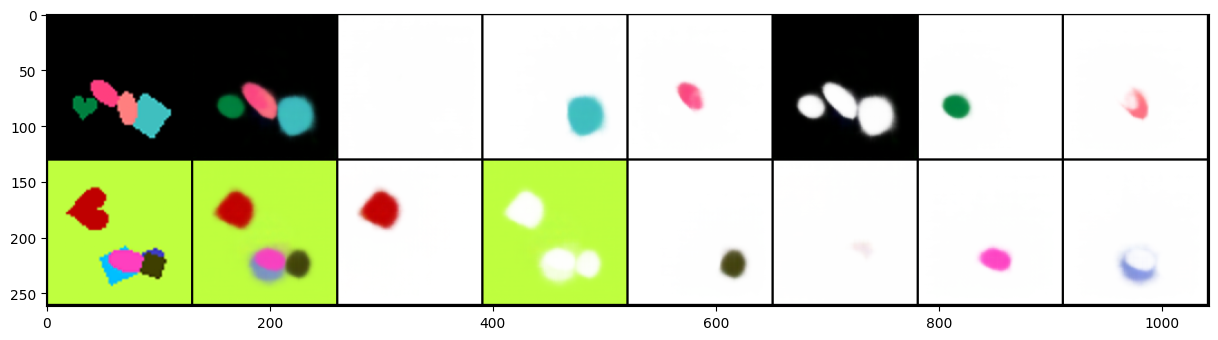

In [26]:
images_to_show = []
for i, image in enumerate(images):
    image = image.cpu()
    recon_combined = recon_combineds[i].cpu().detach()
    recon = recons[i].permute(0,3,1,2).cpu().detach()
    mask = masks[i].permute(0,3,1,2).cpu().detach()

    images_to_show.append(image)
    images_to_show.append(recon_combined)
    
    for j in range(num_slots):
        picture = recon[j] * mask[j] + (1 - mask[j])
        images_to_show.append(picture)

images_to_show = torchvision.utils.make_grid(images_to_show, nrow=num_slots+2)
print(images_to_show.shape)

plt.figure(figsize=(15,2*batch_size))
plt.imshow(images_to_show.permute(1,2,0))
#plt.savefig(os.path.join(args.image_dir, 'reconstructions_{}.png'.format(epoch)))

In [28]:
# Find ARI score
from metrics import adjusted_rand_index

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ari_mean = 0
num_batches = 0
for batch in test_loader:
    images = batch['image'].to(device)
    true_mask = batch['mask'].to(device)
    recon_combineds, recons, masks, slots, _ = model(images, vis_step=None)
    # `masks` has shape: [batch_size, num_slots, width, height, 1].
    # CHECK: `true_mask` has shape: [batch_size, num_entities, width, height].
    # CHECK: true mask is one_hot

    true_mask = torch.flatten(true_mask, start_dim=2, end_dim=3)
    true_mask = torch.permute(true_mask, (0, 2, 1))
    flattened_masks = torch.flatten(masks, start_dim=2, end_dim=4)
    flattened_masks = torch.permute(flattened_masks, (0, 2, 1))
    ari = adjusted_rand_index(true_mask, flattened_masks)
    ari_mean += ari.mean().item()
    num_batches += 1
print("Ari: ", ari_mean / num_batches)

torch.Size([2, 64, 64])
torch.Size([2, 16384, 6])


RuntimeError: einsum(): subscript j has size 64 for operand 1 which does not broadcast with previously seen size 16384